In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

datos = pd.read_excel('C:/Users/Noel/Documents/Universidad/4º/2º Cuatri/Trabajo Fin de Grado/TFG_Datos.xlsx', usecols=['Fecha', 'P','G(i)','H_sun','T2m','WS10m','Int'])
#datos = pd.read_csv('C:/Users/Noel/Desktop/TFM/TFG_Datos.csv')
print(datos)

                  Fecha    P  G(i)  H_sun   T2m  WS10m  Int
0      2017-01-01 00:01  0.0   0.0    0.0  4.59   2.07  0.0
1      2017-01-01 01:01  0.0   0.0    0.0  4.57   2.07  0.0
2      2017-01-01 02:01  0.0   0.0    0.0  4.76   1.93  0.0
3      2017-01-01 03:01  0.0   0.0    0.0  5.34   1.79  0.0
4      2017-01-01 04:01  0.0   0.0    0.0  5.09   1.79  0.0
...                 ...  ...   ...    ...   ...    ...  ...
35059  2020-12-31 19:01  0.0   0.0    0.0  7.86   4.34  0.0
35060  2020-12-31 20:01  0.0   0.0    0.0  7.75   3.79  0.0
35061  2020-12-31 21:01  0.0   0.0    0.0  7.69   3.24  0.0
35062  2020-12-31 22:01  0.0   0.0    0.0  7.66   3.03  0.0
35063  2020-12-31 23:01  0.0   0.0    0.0  7.54   3.59  0.0

[35064 rows x 7 columns]


In [2]:
datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d %H:%M')
datos = datos.set_index('Fecha')
datos = datos.sort_index()
datos.index = datos.index.to_period('T')
datos.head()


,P,G(i),H_sun,T2m,WS10m,Int
Fecha,,,,,,
2017-01-01 00:01,0.0,0.0,0.0,4.59,2.07,0.0
2017-01-01 01:01,0.0,0.0,0.0,4.57,2.07,0.0
2017-01-01 02:01,0.0,0.0,0.0,4.76,1.93,0.0
2017-01-01 03:01,0.0,0.0,0.0,5.34,1.79,0.0
2017-01-01 04:01,0.0,0.0,0.0,5.09,1.79,0.0


In [17]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(dataframe, tr_size=0.8, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Ntst = N - Ntrain # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    test = dataframe[Ntrain:]

    return train, test

# Prueba de la función
entrenamiento, prueba = train_val_test_split(datos)

print(f'Tamaño set de entrenamiento: {entrenamiento.shape}')
print(f'Tamaño set de prueba: {prueba.shape}')

Tamaño set de entrenamiento: (28051, 6)
Tamaño set de prueba: (7013, 6)


In [37]:
df_concat = pd.concat([entrenamiento, prueba], ignore_index=True)

In [4]:
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX


def fit_sarimax_with_auto_arima(y, X, seasonal, m, verbose):
    """
    Ajusta un modelo SARIMAX usando los mejores parámetros encontrados por auto_arima.

    Args:
        y (DF): Serie temporal objetivo.
        X (DF): Variables exógenas.
        seasonal (bool): Si se debe buscar estacionalidad.
        m (int): Frecuencia estacional.
        verbose (bool): Si mostrar o no el progreso de auto_arima.

    Returns:
        model_fit (SARIMAXResultsWrapper): Modelo ajustado de SARIMAX.
        best_params (dict): Diccionario con los mejores parámetros encontrados.
    """
    
    # Buscar los mejores parámetros con auto_arima
    auto_model = auto_arima(
        y,
        exogenous=X,
        seasonal=seasonal,
        m=m,
        trace=verbose,
        start_p=0, max_p=1,
        start_q=0, max_q=1,
        start_P=0, max_P=1,
        start_Q=0, max_Q=0,
        max_order=5,       # p+q+P+Q ≤ 5
        stepwise=True,
        suppress_warnings=True,
        error_action='trace'
    )

    # Extraer los parámetros óptimos
    order = auto_model.order
    seasonal_order = auto_model.seasonal_order if seasonal else (0, 0, 0, 0)

    if verbose:
        print(f"Mejores parámetros encontrados: order={order}, seasonal_order={seasonal_order}")

    # Ajustar modelo SARIMAX con esos parámetros
    sarimax_model = SARIMAX(
        y,
        exog=X,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    model_fit = sarimax_model.fit(disp=False)

    # Retornar modelo entrenado y parámetros usados
    return model_fit, {"order": order, "seasonal_order": seasonal_order}


modelo, dicc = fit_sarimax_with_auto_arima(
    y=entrenamiento['P'].shift(-1).dropna(),  # Serie objetivo sin NaN
    X=entrenamiento[:-1],    # Variables exógenas alineadas
    seasonal=True, 
    m=24, 
    verbose=True
)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=340745.031, Time=0.28 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=335277.850, Time=36.53 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=339830.957, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=340743.031, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=339484.928, Time=0.32 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=335322.884, Time=153.87 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=42.33 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=335285.125, Time=21.23 sec
 ARIMA(1,1,0)(1,0,0)[24]             : AIC=335275.850, Time=6.97 sec
 ARIMA(1,1,0)(0,0,0)[24]             : AIC=339482.928, Time=0.24 sec
 ARIMA(0,1,0)(1,0,0)[24]             : AIC=335320.891, Time=2.55 sec
 ARIMA(1,1,1)(1,0,0)[24]             : AIC=inf, Time=11.29 sec
 ARIMA(0,1,1)(1,0,0)[24]             : AIC=335283.125, Time=7.45 sec

Best model:  ARIMA(1,1,0)(1,0,0)[24]          
Total fit time: 284.

In [18]:
predicciones = []
for i in range(len(prueba)):
    forecast = modelo.get_forecast(steps=1, exog=prueba[i:i+1])
    predicciones.append(forecast.predicted_mean.values[0])


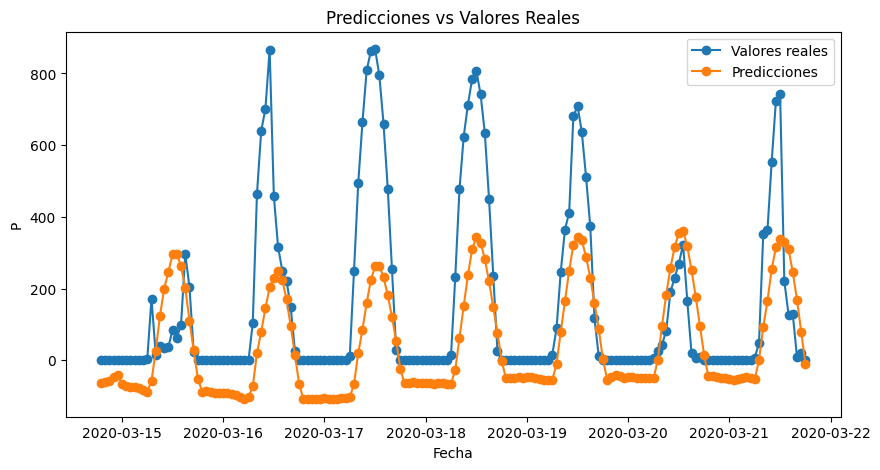

In [38]:
import matplotlib.pyplot as plt

# Supongamos que predicciones son para 2 pasos: t+1 y t+2
steps = 168
forecast_index = prueba.index[:steps].to_timestamp()  # Convertir PeriodIndex a DatetimeIndex

plt.figure(figsize=(10,5))

# Graficar valores reales
plt.plot(forecast_index, prueba['P'][1:steps+1], label='Valores reales', marker='o')

# Graficar predicciones
plt.plot(forecast_index, predicciones[:steps], label='Predicciones', marker='o')

# Graficar intervalo de confianza


plt.legend()
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('P')
plt.show()


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(prueba['P'], predicciones)
rmse = np.sqrt(mean_squared_error(prueba['P'], predicciones))
mse=mean_squared_error(prueba['P'], predicciones)


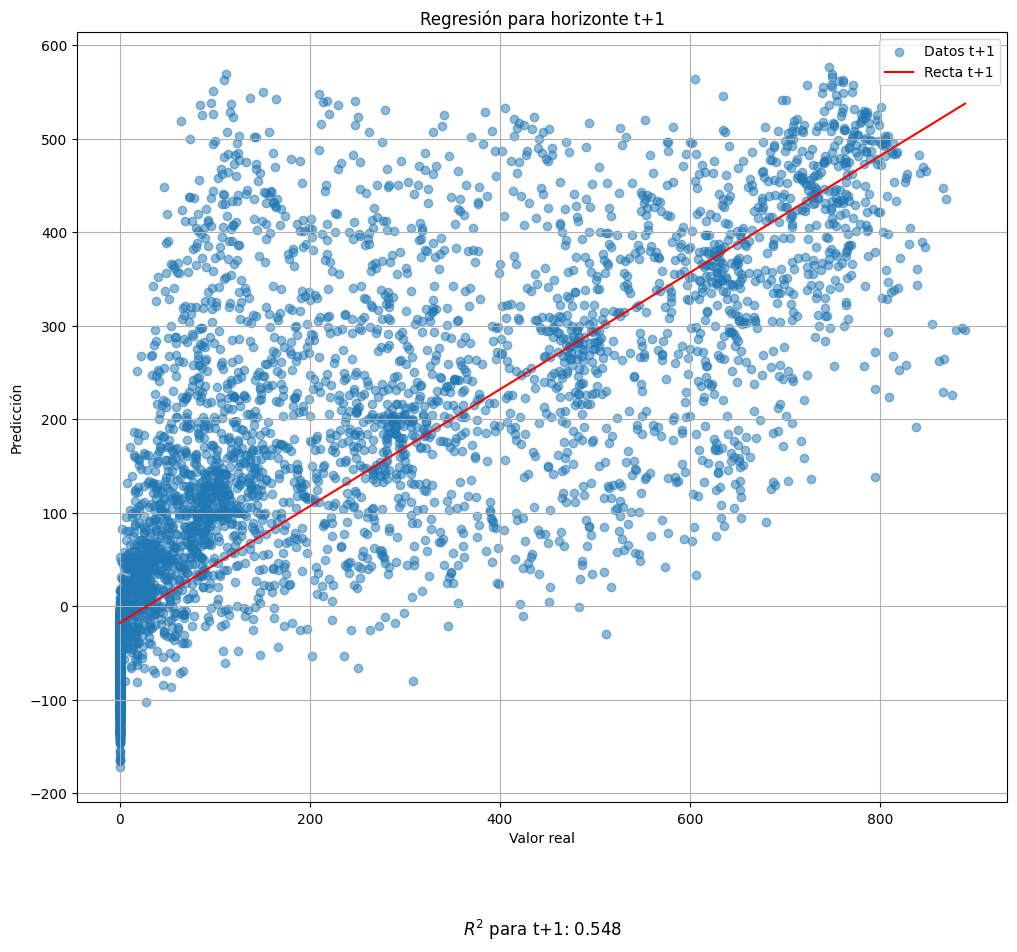

In [ ]:
from sklearn.metrics import r2_score

fig, axs = plt.subplots(1,1,figsize=(12,10))
x = prueba['P']
y = predicciones

# Ajuste lineal: coeficientes [pendiente, intercepto]
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

# Dibujar puntos reales vs predichos
axs.scatter(x, y, label=f'Datos t+1', alpha=0.5)

# Dibujar recta de regresión
x_line = np.linspace(np.min(x), np.max(x), 100)
axs.plot(x_line, poly1d_fn(x_line), label=f'Recta t+1',color='red')

# R2 para info en leyenda
r2 = r2_score(x, y)
  # Texto debajo del gráfico
axs.text(0.5, -0.15, f"$R^2$ para t+1: {r2:.3f}",
        transform=axs.transAxes,
        ha='center', va='top', fontsize=12)

axs.set_xlabel("Valor real")
axs.set_ylabel("Predicción")
axs.legend()
axs.set_title(f'Regresión para horizonte t+1')
axs.grid(True)